In [142]:
import sys
import os
import json
import pandas as pd
import numpy as np
import random
import copy
from datetime import datetime
from collections import Counter, defaultdict

# Visualization packages
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Append system path
sys.path = [p for p in sys.path if not p.endswith('../..')]  # Cleans duplicated '../..'
sys.path.insert(0, '../')  # This adds `src` to the path

from helpers import io, filters, constants
from analysis import util
from web_analysis import parse_robots
from web_analysis import robots_util


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
url_token_lookup = robots_util.URLTokenLookup('pretrain_data/relevant_url_token_counts.csv') # 'c4', 'rf', 'dolma'
c4_url_to_counts = url_token_lookup.get_url_to_token_map("c4")

In [239]:
# URL -> Date -> Robots.txt raw text
head_robots = io.read_json("robots_data/temporal_robots_head.json")
random_10k_robots = io.read_json("robots_data/temporal_robots_rand_10k.json")
joined_robots = copy.deepcopy(head_robots)
joined_robots.update(random_10k_robots)
print(len(head_robots))
print(len(random_10k_robots))
print(len(joined_robots))

830
6230
7059


In [240]:
# Print out start and end years of the data:

all_times = []
for k, vs in joined_robots.items():
    for time in vs:
        all_times.append(time)
all_times = set(all_times)
print(min(all_times))
print(max(all_times))
print(sorted(all_times)[:10])
print(sorted(all_times)[-10:])

2016-01-01
2024-04-19
['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09', '2016-01-10']
['2024-04-10', '2024-04-11', '2024-04-12', '2024-04-13', '2024-04-14', '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19']


In [ ]:
# run compute_url_date_agent_status for random and head.
# filter URLs for random vs head before 
# compute size vs robots restritiveness (All Agents, OpenAI, Google) stats
# time, size, robots

In [314]:
agent_groups_to_track = robots_util.get_bot_groups()
agents_to_track = robots_util.get_bots()
# {URL --> Date --> Agent --> Status}
url_robots_summary = robots_util.compute_url_date_agent_status(
    data=joined_robots, 
    # relevant_agents=agents_to_track)
    relevant_agents=[v for vs in agent_groups_to_track.values() for v in vs])

In [368]:
# top N sample: TODO: Top 1k vs top 800 token info.
top_c4_urls = url_token_lookup.top_k_urls("c4", 1000)
url_robots_summary_head = {k: url_robots_summary[k] for k in top_c4_urls if k in top_c4_urls}
url_robots_summary_rand = {k: url_robots_summary[k] for k, _ in random_10k_robots.items()}

Number of tokens in 1000 URLs: 13808461301 | 8.12% of c4


In [361]:

def plot_size_against_restrictions(
    url_robots_summary,
    size_bucket_to_urls,
    agent_group,
    setting=None
):
    agent_names = robots_util.get_bots(agent_group, setting=setting)
    # {URL --> Date --> Agent --> Status} --> {URL —> status}
    current_url_status = robots_util.get_latest_url_robot_statuses(url_robots_summary, agent_names)
    print(len(current_url_status))

    set(current_url_status.keys())

    cat_keys = ["all", "some", "none"]
    data_groups = defaultdict(lambda: [0, 0, 0])
    url_to_bucket_key = {url: sz for sz, urls in size_bucket_to_urls.items() for url in urls}
    # data: "bucket range": [full restrictions, some restrictions, no restrictions]
    for url, status in current_url_status.items():
        if not status:
            print(url)
            print(status)
        data_groups[url_to_bucket_key[url]][cat_keys.index(status)] += 1
    
    print(data_groups)

    return util.plot_stackedbars(
        data_groups, 
        title=None, 
        category_names=['Full Restrictions', 'Some Restrictions', 'No Restrictions'],
        custom_colors=['#e04c71','#e0cd92','#82b5cf'],
        group_order=sorted(size_bucket_to_urls.keys(), key=lambda x: int(x.split('-')[0])), 
        total_dsets=len(url_to_bucket_key), 
        legend=True, 
        savepath=f"paper_figures/altair/robots_restrictions_vs_token_count_{agent_group}.json"
    )

In [362]:
size_bucket_to_urls = robots_util.bucket_urls_by_size(
    c4_url_to_counts, 
    bucket_boundaries=[0, 1000, 10000, 50000, 1000000, 10000000, 50000000, 9999999999999999]
)

Bucket 0-1000: 4729
Bucket 1000-10000: 4064
Bucket 10000-50000: 1411
Bucket 50000-1000000: 896
Bucket 1000000-10000000: 2441
Bucket 10000000-50000000: 429
Bucket 50000000-9999999999999999: 19


In [374]:
plot_size_against_restrictions(
    url_robots_summary,
    size_bucket_to_urls,
    "OpenAI",
    setting="train"
)

['GPTBot']
7059
defaultdict(<function plot_size_against_restrictions.<locals>.<lambda> at 0x32e616ca0>, {'10000000-50000000': [77, 167, 109], '1000000-10000000': [73, 223, 172], '50000000-9999999999999999': [5, 8, 4], '10000-50000': [16, 636, 327], '0-1000': [36, 1315, 886], '50000-1000000': [11, 220, 133], '1000-10000': [43, 1684, 914]})


alt.LayerChart(...)

In [244]:

# {Period --> Agent --> Status --> set(URLs)}
robots_filled_status_head_summary = robots_util.prepare_robots_temporal_summary(
    url_robots_summary=url_robots_summary_head, 
    # group_to_agents={k: [k] for k in agents_to_track},
    group_to_agents=agent_groups_to_track,
    start_time='2016-01-01', 
    end_time='2024-04-30',
    time_frequency="M",
)
robots_filled_status_rand_summary = robots_util.prepare_robots_temporal_summary(
    url_robots_summary=url_robots_summary_rand, 
    # group_to_agents={k: [k] for k in agents_to_track},
    group_to_agents=agent_groups_to_track,
    start_time='2016-01-01', 
    end_time='2024-04-30',
    time_frequency="M",
)


Number of tokens in 800 URLs: 12542618890 | 7.38% of c4
2016-01
2016-11
2017-09
2018-07
2019-05
2020-03
2021-01
2021-11
2022-09
2023-07
2016-01
2016-11
2017-09
2018-07
2019-05
2020-03
2021-01
2021-11
2022-09
2023-07


In [256]:

# Dataframe w/ [Period, Agent, Status, count(URLs or tokens)]
robots_temporal_head_summary = robots_util.robots_temporal_to_df(
    robots_filled_status_head_summary,
    url_to_counts=c4_url_to_counts,
)
# Dataframe w/ [Period, Agent, Status, count(URLs or tokens)]
robots_temporal_rand_summary = robots_util.robots_temporal_to_df(
    robots_filled_status_rand_summary,
    url_to_counts=c4_url_to_counts,
)

In [257]:
robots_temporal_head_summary

,period,agent,status,count,tokens
0,2016-01,*All Agents*,N/A,429,6788295764
1,2016-01,*All Agents*,some,272,4369335297
2,2016-01,*All Agents*,none,96,1358192186
3,2016-01,*All Agents*,all,3,26795643
4,2016-01,*,N/A,429,6788295764
...,...,...,...,...,...
4395,2024-04,Facebook,all,17,205598152
4396,2024-04,Internet Archive,some,412,7002545645
4397,2024-04,Internet Archive,N/A,138,1988186014
4398,2024-04,Internet Archive,all,15,305139482


In [ ]:
1. Adjust graphs to use agent sets, not just agents [X]
2a. Get tokens lookup saved and working [X]
2b. Head sample selection (quantity and corpus) [X]
2. Plot tokens, not just counts [X]
3a. Fix websites dead vs no robots.
3. Look at head vs random [X]
4. Compute head vs random correlations
5. Plot head vs random correlation or scatter or something? [X]
6. Rate of change over time
7. Invert parsing diction

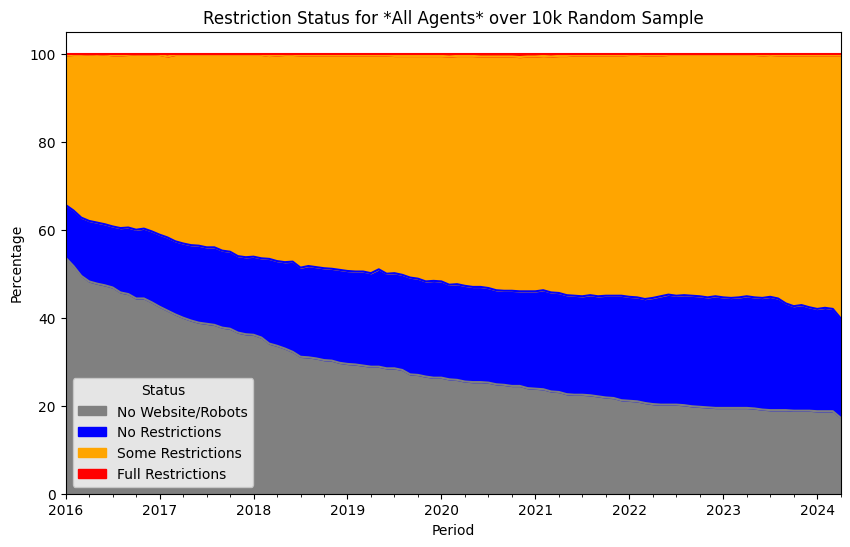

<Figure size 640x480 with 0 Axes>

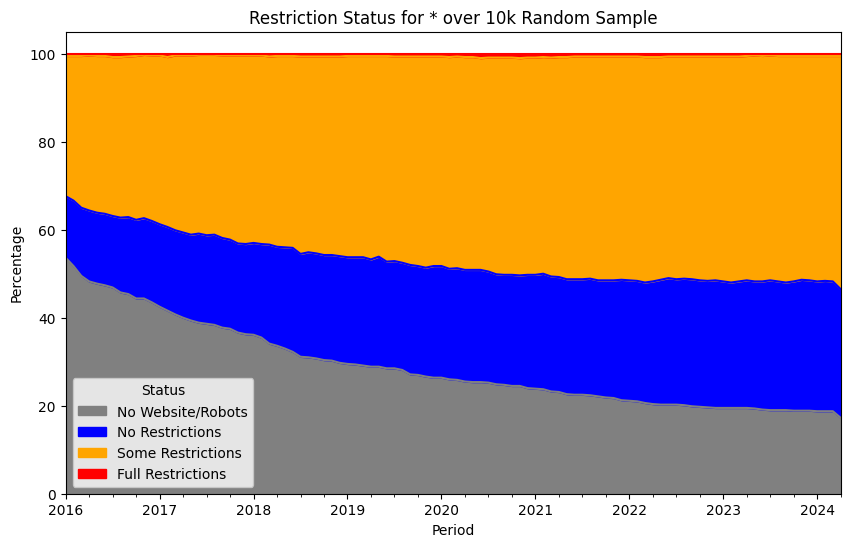

<Figure size 640x480 with 0 Axes>

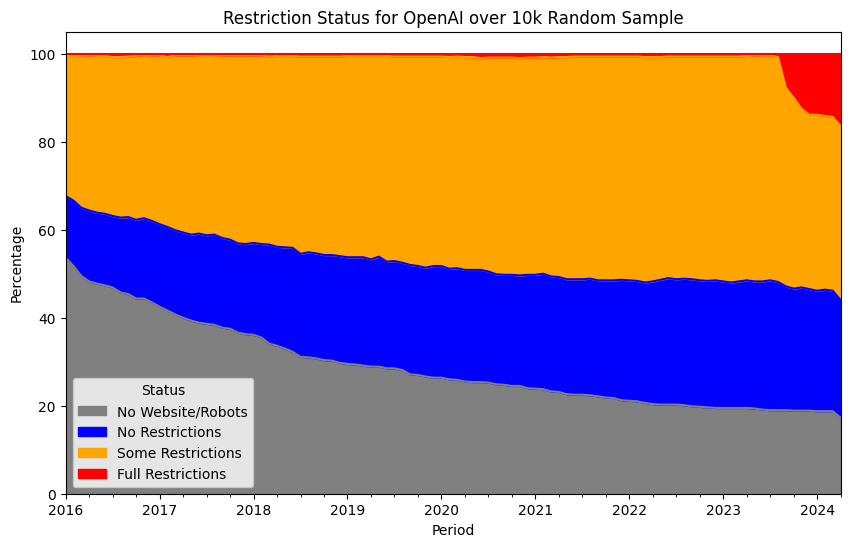

<Figure size 640x480 with 0 Axes>

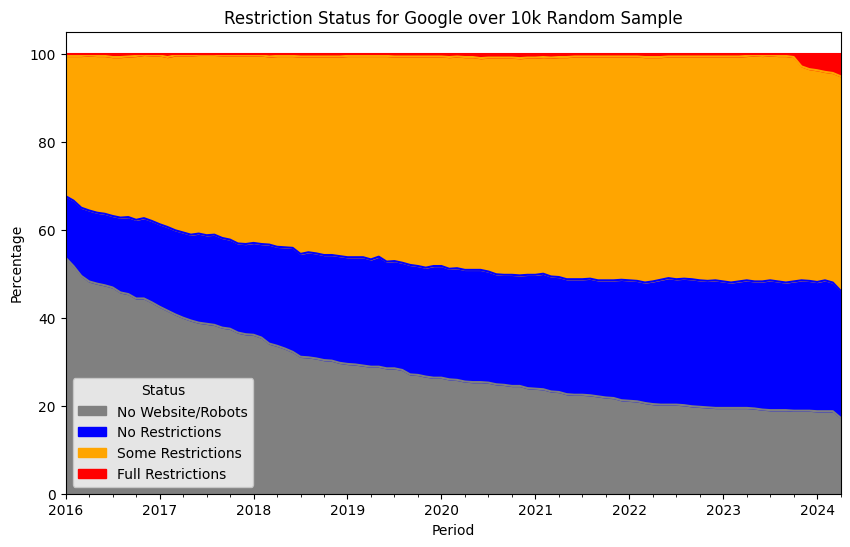

<Figure size 640x480 with 0 Axes>

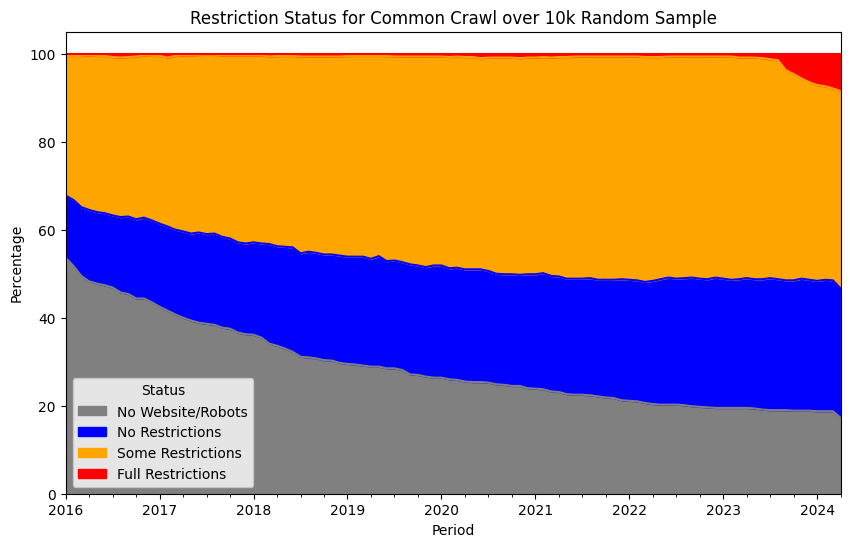

<Figure size 640x480 with 0 Axes>

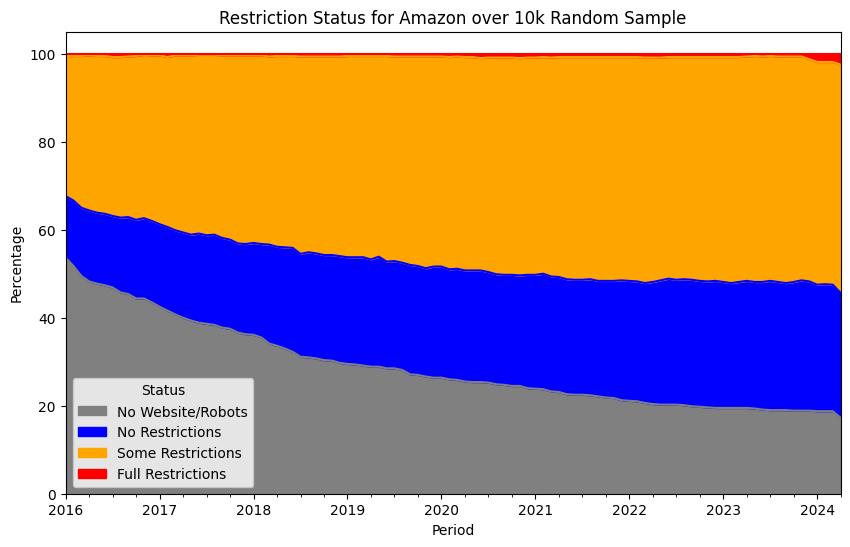

<Figure size 640x480 with 0 Axes>

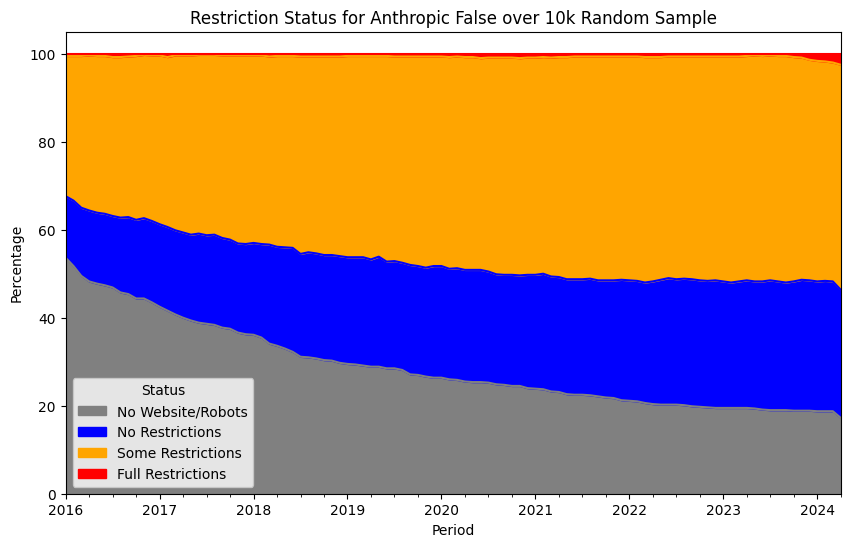

<Figure size 640x480 with 0 Axes>

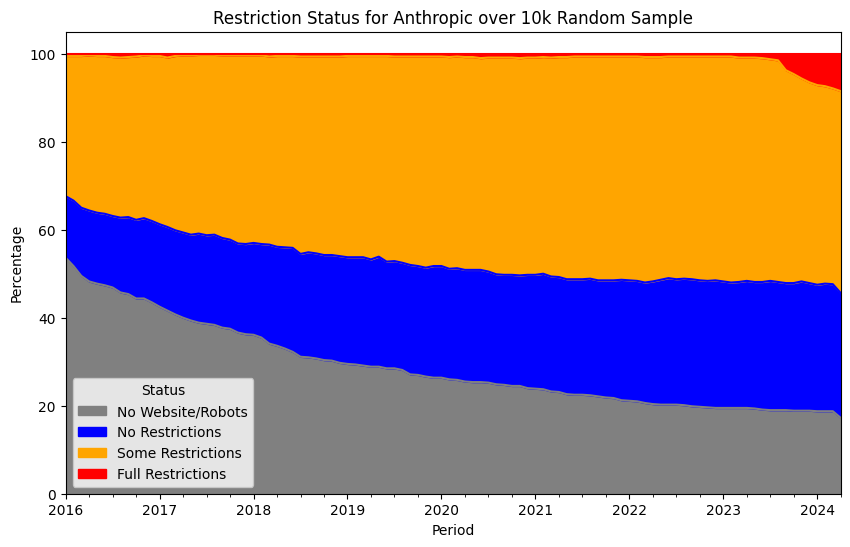

<Figure size 640x480 with 0 Axes>

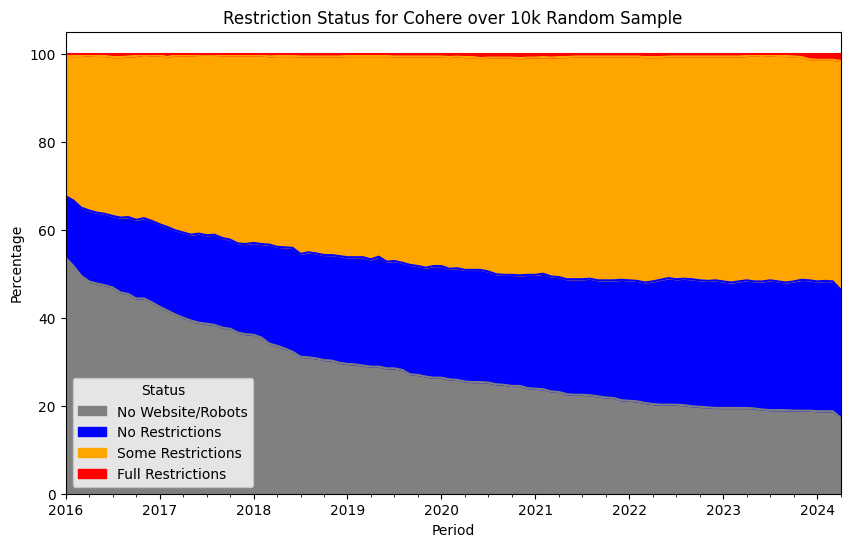

<Figure size 640x480 with 0 Axes>

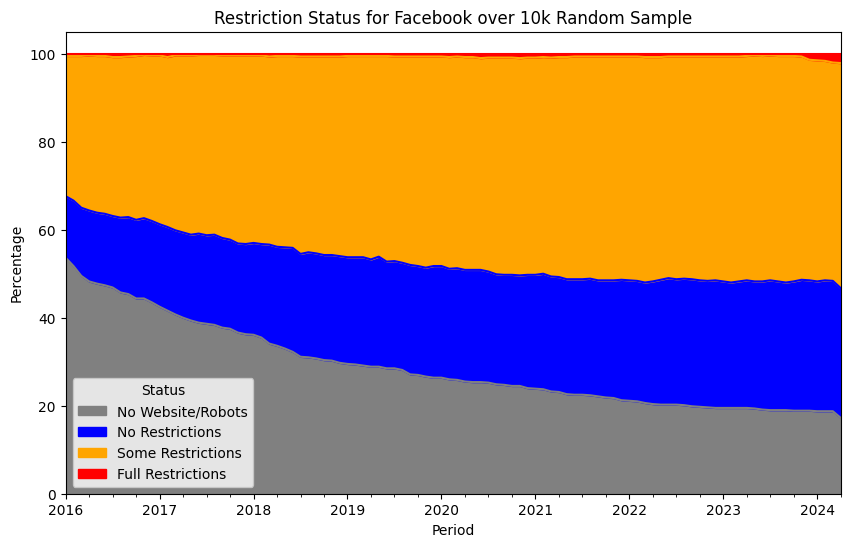

<Figure size 640x480 with 0 Axes>

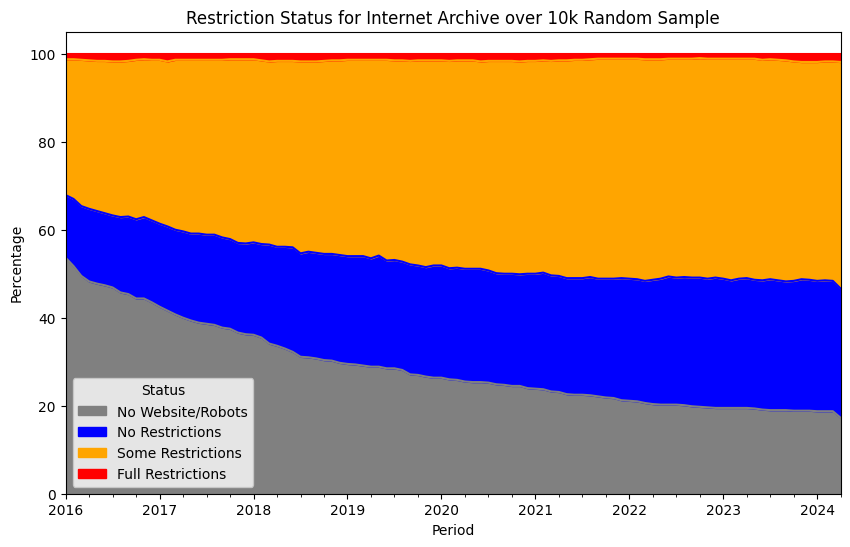

<Figure size 640x480 with 0 Axes>

In [370]:


# for agent_type in robots_util.BOT_TRACKER.keys():

def plot_robots_time_map(df, agent_type, val_key):

    # Filter the DataFrame for the relevant agent
    filtered_df = df[df['agent'] == agent_type]
    
    # Group by 'period' and 'status', and sum up the 'count'
    grouped_df = filtered_df.groupby(['period', 'status'])[val_key].sum().unstack(fill_value=0)
    
    # Optional: Reorder the columns as desired (replace 'status1', 'status2', etc., with your actual status names)
    ordered_statuses = ['N/A', 'none', 'some', 'all']  # Example: reorder as per your preference
    grouped_df = grouped_df[ordered_statuses]
    
    # Calculate the total counts for each period
    total_counts = grouped_df.sum(axis=1)
    
    # Calculate the percentage of each status per period
    percent_df = grouped_df.div(total_counts, axis=0) * 100
    
    # Specify colors for each stack (ensure this matches the order of statuses in 'ordered_statuses')
    colors = ['gray', 'blue', 'orange', 'red']  # Assign colors to each status
    
    # Optional: Rename columns for custom labels in the legend
    percent_df.columns = ['No Website/Robots', 'No Restrictions', 'Some Restrictions', 'Full Restrictions']  # Example labels
    # gray (n/a), blue (some), red (none), orange (all)
    # Plotting the stacked area chart
    # percent_df.plot(kind='area', stacked=True, figsize=(10, 6))#, color=colors)
    percent_df.plot(kind='area', stacked=True, figsize=(10, 6), color=colors)
    
    # plt.title(f"Restriction Status for {agent_type} over C4 Top 800")
    plt.title(f"Restriction Status for {agent_type} over 10k Random Sample")
    plt.xlabel('Period')
    plt.ylabel('Percentage')
    plt.legend(title='Status')
    plt.show()
    plt.clf()


# for agent in agents_to_track:
#     plot_robots_time_map(robots_temporal_summary, agent)

for group in agent_groups_to_track:
    plot_robots_time_map(robots_temporal_head_summary, group, val_key="count")

In [ ]:
# 2. "*" over time, compared to a few agents [Google, OpenAI, Meta, Cohere, Anthropic, etc]

In [ ]:
Notes:

* Take All Agents and subtract it from the other plots to see the diffs between agents.
* How do these charts vary with different quantiles for number of tokens. (Behavior diffs for token rich and token poor)

* Incompatability between Robots.txt and ToS? Robots.txt is an encoded ToS for scrapers. Is there more intention detailed in the ToS than the robots?
* Robots and ToS update rate. --> How often that the other is updated within T time (robots and ToS).
* Analysis: Of all websites that restrict at least one AI bot, what other bots do they restrict? E.g. if you restrict cohere, you probaby also restrict OpenAI
P(Cohere restricted | OpenAI restricted)
* Include Midjourney, CCBot, IAbot, etc
* Vertical lines that show when bots get introduced.

* Restrictions are rising across the board.
* Company-wise restrictions
* Compare for each company their scraping restrictions vs RAG restrictions vs AI bot restrictions (OpenAI, Anthropic)

In [ ]:
- company-wise analysis: by agent, by RAG, by scraping
- rate of change over time
- most added agent in each period (bi-annually?)
- token quantity-adjusted
- correlation between token size and robots.txt restrictions?
- overleaf table for agent mentions and status

dict_keys([Period('2016-01', 'M'), Period('2016-02', 'M'), Period('2016-03', 'M'), Period('2016-04', 'M'), Period('2016-05', 'M'), Period('2016-06', 'M'), Period('2016-07', 'M'), Period('2016-08', 'M'), Period('2016-09', 'M'), Period('2016-10', 'M'), Period('2016-11', 'M'), Period('2016-12', 'M'), Period('2017-01', 'M'), Period('2017-02', 'M'), Period('2017-03', 'M'), Period('2017-04', 'M'), Period('2017-05', 'M'), Period('2017-06', 'M'), Period('2017-07', 'M'), Period('2017-08', 'M'), Period('2017-09', 'M'), Period('2017-10', 'M'), Period('2017-11', 'M'), Period('2017-12', 'M'), Period('2018-01', 'M'), Period('2018-02', 'M'), Period('2018-03', 'M'), Period('2018-04', 'M'), Period('2018-05', 'M'), Period('2018-06', 'M'), Period('2018-07', 'M'), Period('2018-08', 'M'), Period('2018-09', 'M'), Period('2018-10', 'M'), Period('2018-11', 'M'), Period('2018-12', 'M'), Period('2019-01', 'M'), Period('2019-02', 'M'), Period('2019-03', 'M'), Period('2019-04', 'M'), Period('2019-05', 'M'), Perio

In [190]:
list(head_robots.keys())[0]

'http://www.angelfire.com/robots.txt'

In [ ]:
Pretrain Data Sources Analysis:

0. Table: Methodology -- what metadata we collected/annotated (and how). [WIP]
1. Figure: Temporal changes in Robots / ToS (somehow over a collection or multiple companies?) [Waiting on ToS]
2. Figure: Robots / ToS contradiction matrix [Waiting on ToS]
3. Table: Robots permission differences by company. [WIP]
4. Figure: Robots / ToS restrictivness by website num tokens (i.e. head vs tail) [WIP]
5. Figure: Commercial/market copyright concerns and comparison to WildChat + EU AI Act [WIP, waiting on WildChat]

In [ ]:
Datasets Analysis:

(License: NC, C, Unspecified) x (Terms: Unspecified/None, NC, C).

0. License & source (terms) restriction differences between Text, Video, Speech. (normalized stacked bar chart) [WIP]
1. Source domains by Text, Video, Speech: scraped, synthetic, crowdsourced, ....  (normalized stacked bar chart) [WIP]

Extension: 

2. Creator distribution for Text, Video, Speech by geography and organization type [WIP]
3. Temporal breakdown of license restriction categories by Text, Video, Speech [WIP]
4. License Type by modality for Text, Video, Speech [WIP]
(Will run statistical tests checking if diffs between Text,Video,Speech are significant on all of these. [WIP]

In [ ]:
Tracks: Pretraining, Video, Speech, Text Finetuning.

# People who restrict Anthropic but not OpenAI. <-- public awareness of organizations is the driving force here. 
# Ordered by notoriety. (Confusion matrix)